In [1]:
import numpy as np
import numpy.ma as ma
from numpy import diff
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

import xarray as xr

In [2]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_pulse10'
gridT = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_T.nc')
gridU = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_U.nc')
gridV = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_V.nc')
gridW = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_W.nc')

sal = np.tile(gridT['vosaline'][:,:20,:,:],(1,1))
tem = np.tile(gridT['votemper'][:,:20,:,:],(1,1))
utau = np.tile(gridU['sozotaux'],(1,1))
vtau = np.tile(gridV['sometauy'],(1,1))
vE = gridW['veddyvisc'][:,:20,:,:]
depthw = gridW['depthw'][:20]
deptht = gridT['deptht'][:20]
nav_lat = gridT['nav_lat']
nav_lon = gridT['nav_lon']

/home/imachuca/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


In [3]:
grid_g = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/grid_02.nc')
lon_g_grid = grid_g['grid_lons'][:-3,:-3]
lat_g_grid = grid_g['grid_lats'][:-3,:-3]

In [4]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']
coord_nav_lat = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# Wind stress and eddy viscosity

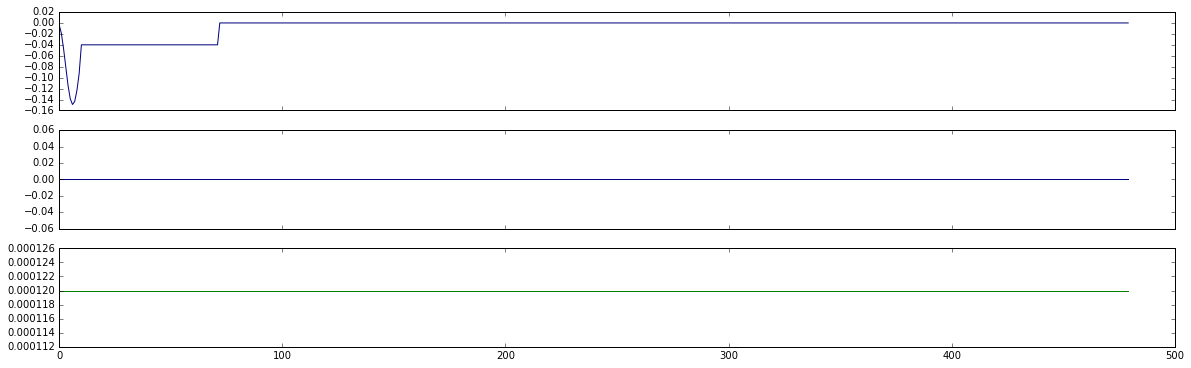

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6), sharex=True)
ax1.plot(utau[:,100,100], c='navy')
ax2.plot(vtau[:,100,100], c='navy')
ax3.plot(vE[:,0,100,100], c='y')
ax3.plot(vE[:,2,100,100], c='r')
ax3.plot(vE[:,4,100,100], c='b')
ax3.plot(vE[:,7,100,100], c='g')

In [6]:
utau[:20,100,100]

array([-0.00275653, -0.01852737, -0.04660851, -0.08087862, -0.11386727,
       -0.13838336, -0.14908271, -0.14363299, -0.12322217, -0.09229956,
       -0.04      , -0.04      , -0.04      , -0.04      , -0.04      ,
       -0.04      , -0.04      , -0.04      , -0.04      , -0.04      ])

# Coriolis parameter

$$f(\lambda)= 2 \Omega \sin(\lambda)$$

$$\Omega = \frac{2 \pi}{24 hours}$$

The average latitude at the northern boundary is 70.943. The average coriolis parameter is 0.0001374. fpar was calculated at all points along the boundary.

In [7]:
indN = -2
latN = nav_lat[indN,:]
omega = (2 * np.pi) / (24 * 60 * 60)
f = 2 * omega * np.sin(np.deg2rad(latN))

In [8]:
latN.shape, f.shape

((237,), (237,))

# Ekman layer thickness

$$\delta = \sqrt \frac{2\nu_E}{f}$$

In [37]:
indt = 9
vEN = vE[indt, :, indN, :]
fN = np.tile(f,(vEN.shape[0],1))
delta = np.sqrt((2 * vEN) / fN)

In [38]:
vEN.shape, fN.shape, delta.shape, delta.max(), delta.min()

/home/imachuca/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


((20, 237), (20, 237), (20, 237), <xarray.DataArray 'veddyvisc' ()>
 array(1.4009250988068855)
 Coordinates:
     time_centered  object    1-01-01 09:30:00
     time_counter   object    1-01-01 09:30:00
     y              int64 175, <xarray.DataArray 'veddyvisc' ()>
 array(1.314572120267825)
 Coordinates:
     time_centered  object    1-01-01 09:30:00
     time_counter   object    1-01-01 09:30:00
     y              int64 175)

# Density

In [39]:
deps = np.transpose(np.tile(-1 * deptht, (237, 1)))
lats = np.tile(latN, (deps.shape[0], 1))
p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [deps,lats], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

deptht.shape, deps.shape, lats.shape, type(deps), type(lats)

((20,), (20, 237), (20, 237), numpy.ndarray, numpy.ndarray)

In [40]:
SA = sal[indt, :, indN, :]
CT = tem[indt, :, indN, :]
rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

SA.shape, rho.shape, type(SA), type(rho)

((20, 237), (20, 237), numpy.ndarray, numpy.ndarray)

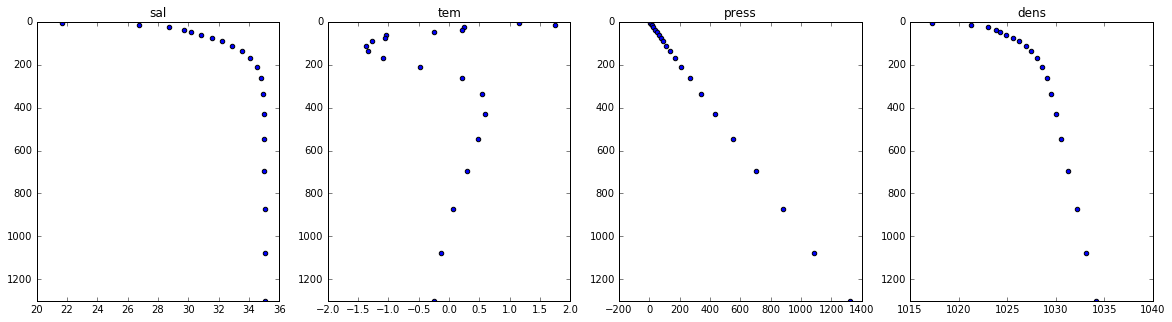

In [41]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
for var, i, ttl in zip([SA, CT, p, rho], np.arange(4), ['sal', 'tem', 'press', 'dens']):
    ax[i].scatter(var[:,100], deptht)
    ax[i].set_ylim([1300, 0])
    ax[i].set_title(ttl)

# Ekman component

$$u_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) - \tau_y sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

$$v_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) + \tau_y cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

In [42]:
type(utau[indt, indN, :])

numpy.ndarray

In [43]:
coeff = (np.sqrt(2)/(rho * fN * delta)) * np.exp(deps / delta)

brackets = (deps / delta) - (np.pi / 4)

tao_x = utau[indt, indN, :]
tao_y = vtau[indt, indN, :]
#tao_x = np.tile(utau[indt, indN, :],(brackets.shape[0],1))
#tao_y = np.tile(vtau[indt, indN, :],(brackets.shape[0],1))

u_E = coeff * ((tao_x * np.cos(brackets)) - (tao_y * np.sin(brackets)))
v_E = coeff * ((tao_x * np.sin(brackets)) + (tao_y * np.cos(brackets)))

In [44]:
coeff.shape, brackets.shape, tao_x.shape, u_E.shape

((20, 237), (20, 237), (237,), (20, 237))

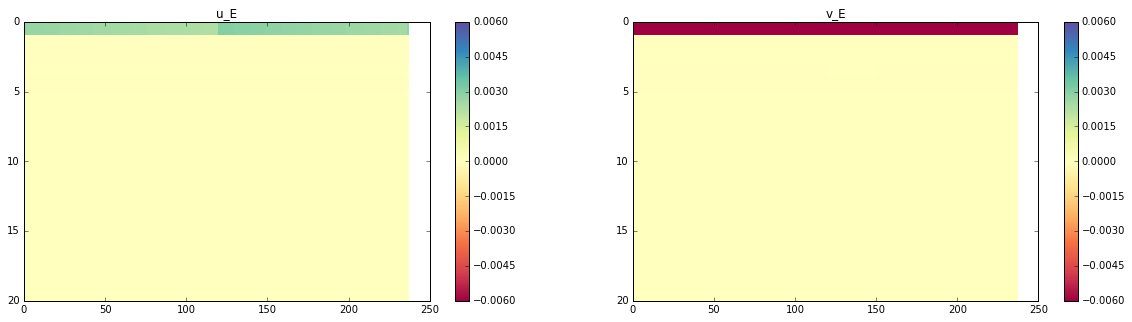

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_E, ttl in zip([ax1, ax2], [u_E, v_E], ['u_E','v_E']):
    p = ax.pcolor(vel_E, vmin=-0.006, vmax=0.006, cmap=cm.Spectral)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)

# Pressure driven component

References:
* http://www.rsmas.miami.edu/users/lbeal/MPO603/Lecture%2012.xhtml
* https://ocw.mit.edu/courses/mechanical-engineering/2-011-introduction-to-ocean-science-and-engineering-spring-2006/readings/geostrophic.pdf
* https://marine.rutgers.edu/dmcs/ms501/2004/Notes/Wilkin20041101.htm
* http://talleylab.ucsd.edu/ltalley/sio210/dynamics_rotation/lecture_dynamics_geostrophy.pdf
* http://onlinelibrary.wiley.com/doi/10.1002/2015JC011579/full

Ekman transport resulting from winds distorts the sea surface height. These distortions (hills and valleys) produce geostrophic currents which dominate the large scale circulation patterns in the upper ocean (Beaufort Gyre). Increased pressure caused by the piling up of surface water causes water to flow away.



$$ v_g = \frac{1}{\rho f} \frac{\partial p}{\partial x} $$

$$ u_g = - \frac{1}{\rho f} \frac{\partial p}{\partial y} $$

And:
$$ p = \int_{-z}^{\eta} g \rho(z) dz = \int_{0}^{\eta} g \rho(z) dz + \int_{-z}^{0} g \rho(z) dz$$

So the geostrophic currents are:
$$u_g = - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{-z}^{0} g \rho(z) dz - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_g = \underbrace{\frac{1}{\rho f}\frac{\partial}{\partial x} \int_{-z}^{0} g \rho(z) dz}_\text{V baroclinic} + \underbrace{\frac{g}{f} \frac{\partial \eta}{\partial x}}_\text{V barotropic}$$


# Barotropic rossby radii
$a_s$: barotropic rossby radius over the shelf

$h_S$: depth for y<S

$$a_s = \frac{\sqrt{gh_s}}{f}$$

$a_d$: barotropic rossby radius off the shelf

$h_d$: depth for y>S

$$a_d = \frac{\sqrt{gh_d}}{f}$$

And:
$$\alpha^2 = \frac{H_S}{H_D}$$

In [46]:
h_s = 80; h_d = 1300
a_s = np.sqrt(9.81 * h_s) / np.mean(fN)
a_d = np.sqrt(9.81 * h_d) / np.mean(fN)
alpha = np.sqrt(h_s / h_d)

print(a_s, a_d, alpha)

203805.675261 821566.942259 0.248069469178


# Allen 1996

$$\eta = - \frac{\int_{t_0}^{t_f} \tau dt}{f^2 a_s} \bigg( \frac{1}{\alpha \sinh (S/a_s) + \cosh(S/a_s)} \bigg) \exp \bigg(\frac{-(y-S)}{a_d} \bigg)$$

Rewritten as:
$$\eta = C \exp \bigg(\frac{-y+S}{a_d} \bigg)$$

where: 

$$ C = - \frac{\int_{t_0}^{t_f} \tau dt}{f^2 a_s} \bigg( \frac{1}{\alpha \sinh (S/a_s) + \cosh(S/a_s)} \bigg)$$

* y=0 at the coast and increases offshore
* S: distance to the shelf break

In [47]:
utau[indt:indt+1,0,0], utau[indt,0,0]

(array([-0.09229956]), -0.092299558222293854)

In [48]:
dt_s = 60*60 
tau_integral = np.trapz(utau[indt:indt+1,0,0], None, dt_s) 
coeff_eta = (-1 * tau_integral) / ((np.mean(fN))**2 * a_s)

tau_integral, utau.max(), utau.min(), coeff_eta

(0.0, 0.0, -0.14908270537853241, -0.0)

In [49]:
x_wall = bathy_file['X'][0,:][-1]
y_wall = bathy_file['Y'][:,0][-1]

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

x_wall, y_wall

(546064.86328401405, 405234.2962823509)

In [50]:
S_y = y_wall - y_break
arg = S_y / a_s
brackets_eta = 1 / ((alpha * np.sinh(arg)) + np.cosh(arg))

S_y, a_s, brackets_eta 

(146259.7140481, 203805.67526067889, 0.68378254018832274)

In [51]:
C = coeff_eta * brackets_eta
C, coeff_eta, brackets_eta

(-0.0, -0.0, 0.68378254018832274)

# Geostrophic currents

$$\frac{\partial \eta}{\partial y} = - \frac{C}{a_d} \exp \bigg(\frac{-y+S}{a_d} \bigg)$$

for:
$$u_g = - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

and:
$$v_g = +\frac{g}{f} \frac{\partial \eta}{\partial x} = 0$$

In [52]:
exp_eta = np.exp(((-1 * y_wall) + S_y) / a_d)
d_eta_dy = (-1 * C / a_d) * exp_eta # make sure negatives make sense

exp_eta, d_eta_dy

(0.72962811573534381, 0.0)

In [53]:
u_g = (-1 * 9.81 / np.mean(fN)) * d_eta_dy
u_g_bc = np.ones_like(u_E) * u_g
v_g_bc = np.zeros_like(v_E)

u_g_bc.shape

(20, 237)

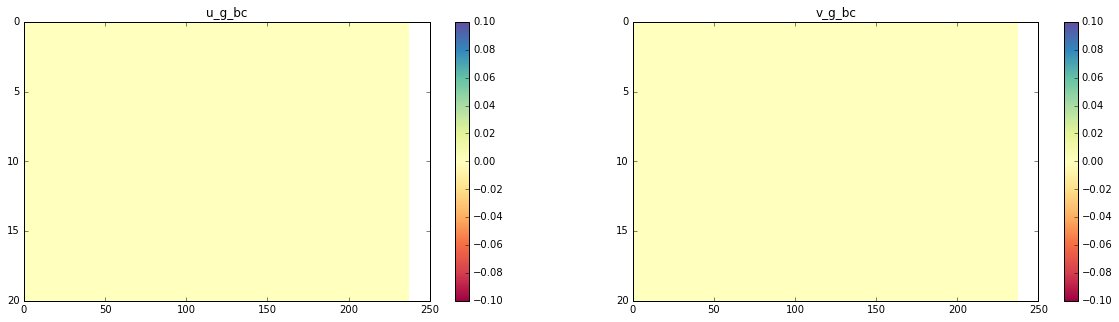

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_g, ttl in zip([ax1, ax2], [u_g_bc, v_g_bc], ['u_g_bc','v_g_bc']):
    p = ax.pcolor(vel_g, cmap=cm.Spectral)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)

# Total velocities

$$u = u_g + u_E$$
$$v = v_g + v_E$$

In [55]:
u_g_bc.shape, u_E.shape, v_g_bc.shape, v_E.shape

((20, 237), (20, 237), (20, 237), (20, 237))

In [56]:
u_tot = u_g_bc + u_E
v_tot = v_g_bc + v_E

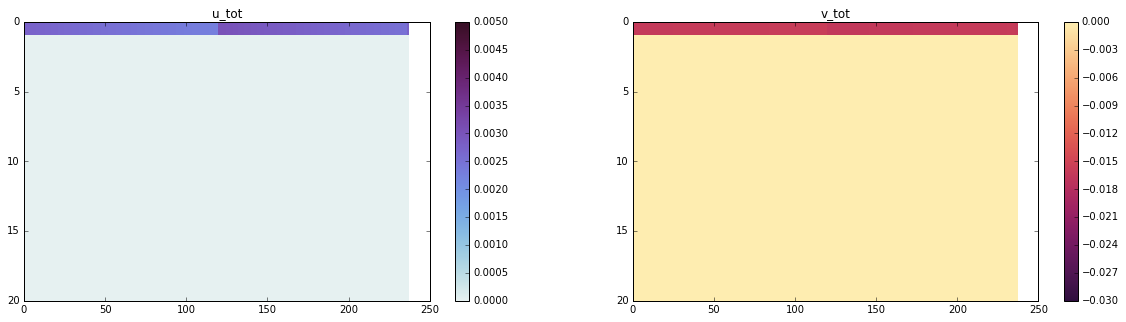

In [58]:
vel_tots = [u_tot, v_tot]
ttls = ['u_tot','v_tot']
cmaps = [cmo.cm.dense, cmo.cm.matter_r]
vmins = [0, -0.03]
vmaxs = [0.005, 0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_tot, ttl, cmap, vmin, vmax in zip([ax1, ax2], vel_tots, ttls, cmaps, vmins, vmaxs):
    p = ax.pcolor(vel_tot, cmap=cmap, vmin = vmin, vmax = vmax)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()
    ax.set_title(ttl)